### Rusty Bargain

### Introduction

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [1]:
#Importing all the necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time
import lightgbm as lgb
import xgboost as xgb

In [2]:
#Reading the data
df = pd.read_csv('/datasets/car_data.csv')

In [3]:
#Getting a first glimpse at the data
display(df.head(10))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,04/04/2016 00:00,0,33775,06/04/2016 19:17
6,01/04/2016 20:48,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,01/04/2016 00:00,0,67112,05/04/2016 18:18
7,21/03/2016 18:54,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,21/03/2016 00:00,0,19348,25/03/2016 16:47
8,04/04/2016 23:42,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,04/04/2016 00:00,0,94505,04/04/2016 23:42
9,17/03/2016 10:53,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,17/03/2016 00:00,0,27472,31/03/2016 17:17


In [4]:
#Obtaining the data general info
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

After getting a first glimpse at the data and the general info, the following appears as relevant:
* There are empty values that need to be addressed in the columns: VehicleType, Gearbox, Model, FuelType and NotRepaired.
* There are categorial values in the columns: DateCrawled, VehicleType, Gearbox, Model, FuelType, Brand, NotRepaired, DateCreated, LastSeen
* Even though there are no empty values on the target, there are cars with a listed price of 0 or too small.
* The price is in Euros, where is the page going to be accessed from? It is not stated.
* It seems important to consider whether all these columns are relevant for the goal. At a first impression, all three columns of dates might not be relevant. As well as the PostalCode, RegistrationMonth and NumberOfPictures. These last three might need a bit of study before disposing of them.
* Do any of the observations actually have any pictures on them?

But, before moving forward with attending to these observations. Let's look for duplicates on the entire dataframe.

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
    
Well done!     
</div>

## Dealing with duplicates

In [5]:
#Looking for duplicates
print('There are', df.duplicated().sum(), 'duplicated rows')

There are 262 duplicated rows


In [6]:
#Getting a glimpse at the duplicated rows
duplicates = df[df.duplicated(keep=False)].sort_values(by=list(df.columns))
display(duplicates.head(10))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
87112,01/04/2016 05:02,6199,coupe,1999,manual,193,3er,150000,5,petrol,bmw,no,01/04/2016 00:00,0,99974,07/04/2016 06:15
90786,01/04/2016 05:02,6199,coupe,1999,manual,193,3er,150000,5,petrol,bmw,no,01/04/2016 00:00,0,99974,07/04/2016 06:15
45825,01/04/2016 10:38,3499,small,2005,manual,86,getz,50000,5,petrol,hyundai,no,01/04/2016 00:00,0,47800,07/04/2016 06:46
142496,01/04/2016 10:38,3499,small,2005,manual,86,getz,50000,5,petrol,hyundai,no,01/04/2016 00:00,0,47800,07/04/2016 06:46
12578,01/04/2016 12:57,1499,wagon,1995,manual,150,5er,150000,6,petrol,bmw,no,01/04/2016 00:00,0,25821,07/04/2016 09:44
112470,01/04/2016 12:57,1499,wagon,1995,manual,150,5er,150000,6,petrol,bmw,no,01/04/2016 00:00,0,25821,07/04/2016 09:44
103188,01/04/2016 18:51,19900,sedan,2015,manual,122,a_klasse,10000,10,petrol,mercedes_benz,no,01/04/2016 00:00,0,86163,01/04/2016 18:51
344269,01/04/2016 18:51,19900,sedan,2015,manual,122,a_klasse,10000,10,petrol,mercedes_benz,no,01/04/2016 00:00,0,86163,01/04/2016 18:51
12016,01/04/2016 19:49,5500,coupe,2003,manual,170,3er,150000,1,petrol,bmw,no,01/04/2016 00:00,0,79108,05/04/2016 16:45
285773,01/04/2016 19:49,5500,coupe,2003,manual,170,3er,150000,1,petrol,bmw,no,01/04/2016 00:00,0,79108,05/04/2016 16:45


In [7]:
#Dropping the duplicated rows and resetting the index
df_cleaned = df.drop_duplicates().reset_index(drop=True)

In [8]:
#Confirming that the duplicates were handled correctly
print('There are', df_cleaned.duplicated().sum(), 'duplicated rows')

There are 0 duplicated rows


## Discarding unnecessary columns

Let's start with defining the columns that we are going to be working with. At this point, it doesn't seem like the columns with dates being: DateCrawled (date profile was downloaded from the database), DateCreated (date of profile creation) and LastSeen (date of the last activity of the user) have any real relevance for our model. We will not be using these columns for the model creation.

In [9]:
#Eliminating the columns with dates from the data
dates = ['DateCrawled', 'DateCreated', 'LastSeen']
df_cleaned = df.drop(dates, axis = 1)

In [10]:
#Is there any information on the number of pictures each car has?
df['NumberOfPictures'].value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

The concept of the column didn't seem relevant for the model originally, and now that we know that there is no info on it, we can safely remove it as well. 

In [11]:
#Dropping the 'NumberOfPictures' column:
df_cleaned = df_cleaned.drop('NumberOfPictures', axis = 1)

We finally need to consider the PostalCode column. I did some research online and even though car's value due change according to the State they are at, the difference is depending mostly on taxes. This is an information that can and should be calculated at a next stage to be clear with the base price and then the extras. It can also be useful for calculating the cost of getting a car from its origin to the buyer, but that also scapes the scope of the project. Due to it, I'll move forward with discarding that information for the model creation.

In [12]:
#Dropping the 'PostalCode' column:
df_cleaned = df_cleaned.drop('PostalCode', axis = 1)

In [13]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Mileage            354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  NotRepaired        283215 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


This way we are left with the columns that we will be using for the model. However, having deleted the timestamp, it is possible that new duplicates appear. I will be now looking for duplicates before moving on to the next step.

In [14]:
#Looking for duplicates after deleting some columns
print('There are', df_cleaned.duplicated().sum(), 'duplicated rows')

There are 27543 duplicated rows


As suspected, new duplicates appeared. We will first take a glimpse at them:

In [15]:
#Getting a glimpse at the duplicated rows
duplicates_c = df_cleaned[df_cleaned.duplicated(keep=False)].sort_values(by=list(df_cleaned.columns))
display(duplicates_c.head(10))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
199835,0,bus,1994,manual,0,transporter,150000,1,gasoline,volkswagen,NaN
283241,0,bus,1994,manual,0,transporter,150000,1,gasoline,volkswagen,NaN
82258,0,bus,1994,manual,68,transporter,150000,5,gasoline,volkswagen,NaN
254668,0,bus,1994,manual,68,transporter,150000,5,gasoline,volkswagen,NaN
107497,0,bus,1995,manual,102,transporter,150000,5,gasoline,volkswagen,no
259813,0,bus,1995,manual,102,transporter,150000,5,gasoline,volkswagen,no
50342,0,bus,1996,auto,110,transporter,150000,0,petrol,volkswagen,no
64344,0,bus,1996,auto,110,transporter,150000,0,petrol,volkswagen,no
233600,0,bus,1996,auto,110,transporter,150000,0,petrol,volkswagen,no
234704,0,bus,1996,auto,110,transporter,150000,0,petrol,volkswagen,no


In [16]:
#Dropping the duplicated rows and resetting the index
df_cleaned = df_cleaned.drop_duplicates().reset_index(drop=True)
#Confirming that the duplicates were handled correctly
print('There are', df_cleaned.duplicated().sum(), 'duplicated rows')

There are 0 duplicated rows


Now that we dealt with the new duplicates, we can proceed to handle the missing values.

## Missing values

Missing values in the 'Model' column

We are going to start dealing with the missing values on the Model column. Since the models are determined by the brands, we will fill in the empty values with the most frequent model when grouped by the brands.

Since all of the columns with missing values have categorical values, I'll create a function that will replace missing values with the mode of the column when grouped by another column used as the reference.

In [17]:
def mode_replace(df, original_column, base_column):
    #Creating a series that contains the mode of the column with missing values, when the data is grouped by the reference column
    most_frequent = df.groupby(base_column)[original_column].agg(lambda x:x.mode())
    #Replacing values with the mode 
    df[original_column] = df[original_column].fillna(df[base_column].map(most_frequent))

In [18]:
mode_replace(df_cleaned, 'Model', 'Brand')
#Confirming there are no missing values in the Model column
print(df_cleaned.info())
#Getting a sample of the data
display(df_cleaned.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326826 entries, 0 to 326825
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              326826 non-null  int64 
 1   VehicleType        291577 non-null  object
 2   RegistrationYear   326826 non-null  int64 
 3   Gearbox            309248 non-null  object
 4   Power              326826 non-null  int64 
 5   Model              326826 non-null  object
 6   Mileage            326826 non-null  int64 
 7   RegistrationMonth  326826 non-null  int64 
 8   FuelType           295704 non-null  object
 9   Brand              326826 non-null  object
 10  NotRepaired        260399 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.4+ MB
None


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN


In [19]:
#Confirming there are no missing values in the Model column
print(df_cleaned.info())
#Getting a sample of the data
display(df_cleaned.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326826 entries, 0 to 326825
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              326826 non-null  int64 
 1   VehicleType        291577 non-null  object
 2   RegistrationYear   326826 non-null  int64 
 3   Gearbox            309248 non-null  object
 4   Power              326826 non-null  int64 
 5   Model              326826 non-null  object
 6   Mileage            326826 non-null  int64 
 7   RegistrationMonth  326826 non-null  int64 
 8   FuelType           295704 non-null  object
 9   Brand              326826 non-null  object
 10  NotRepaired        260399 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.4+ MB
None


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
240873,8800,sedan,2005,auto,272,e_klasse,150000,11,petrol,mercedes_benz,no
3556,950,NaN,2017,manual,55,arosa,150000,7,NaN,seat,no
116938,250,wagon,1999,manual,115,mondeo,150000,3,petrol,ford,no
99265,2350,wagon,2006,manual,120,156,150000,11,lpg,alfa_romeo,no
272144,4200,wagon,2002,manual,131,passat,150000,10,gasoline,volkswagen,no
24528,5890,wagon,2007,manual,135,lancer,100000,1,petrol,mitsubishi,no
177460,250,NaN,2000,NaN,0,focus,100000,0,NaN,ford,NaN
111348,650,sedan,1996,manual,150,3er,150000,5,petrol,bmw,no
209379,1250,sedan,1998,manual,101,golf,150000,6,petrol,volkswagen,NaN
140277,633,sedan,1996,manual,0,civic,150000,0,NaN,honda,NaN


I ran several samples and I discovered that for the 'sonstige_autos' brand, the model that was assigned is []. This is because there is no model assigned originally to any of this brand's appearances on the data. I will be replacing the [] value with 'NA' so that it gives some information.

In [20]:
#Filtering rows with the 'sonstige_autos' brand
sonstige = df_cleaned[df_cleaned['Brand']=='sonstige_autos']
display(sonstige.head(10))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
59,1,suv,1994,manual,286,[],150000,11,NaN,sonstige_autos,NaN
306,200,NaN,2009,NaN,0,[],10000,0,NaN,sonstige_autos,NaN
431,3950,small,2004,auto,5,[],70000,5,gasoline,sonstige_autos,no
650,15000,coupe,1971,NaN,0,[],5000,4,NaN,sonstige_autos,no
661,9900,suv,2000,auto,250,[],150000,4,lpg,sonstige_autos,no
700,6999,sedan,2010,auto,186,[],125000,4,petrol,sonstige_autos,no
985,500,sedan,2010,manual,101,[],70000,1,petrol,sonstige_autos,yes
999,3900,wagon,1990,manual,0,[],30000,5,petrol,sonstige_autos,NaN
1098,11500,bus,1985,auto,160,[],125000,10,petrol,sonstige_autos,NaN
1106,9200,sedan,2005,auto,249,[],150000,10,petrol,sonstige_autos,no


In [21]:
#Replacing the [] value with 'NA' 
df_cleaned['Model'] = df_cleaned['Model'].where(df_cleaned['Model'].apply(lambda x: len(x) > 0), 'NA')
#Confirming it was done correctly
display(df_cleaned[df_cleaned['Brand']=='sonstige_autos'])   

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
59,1,suv,1994,manual,286,NA,150000,11,NaN,sonstige_autos,NaN
306,200,NaN,2009,NaN,0,NA,10000,0,NaN,sonstige_autos,NaN
431,3950,small,2004,auto,5,NA,70000,5,gasoline,sonstige_autos,no
650,15000,coupe,1971,NaN,0,NA,5000,4,NaN,sonstige_autos,no
661,9900,suv,2000,auto,250,NA,150000,4,lpg,sonstige_autos,no
...,...,...,...,...,...,...,...,...,...,...,...
326480,200,NaN,1910,NaN,0,NA,5000,0,petrol,sonstige_autos,NaN
326567,6000,small,2008,manual,155,NA,150000,5,petrol,sonstige_autos,no
326578,1750,NaN,1995,NaN,0,NA,100000,12,NaN,sonstige_autos,NaN
326785,9400,wagon,2007,manual,200,NA,150000,4,gasoline,sonstige_autos,yes


## Missing values on the 'VehicleType' column

The process will be the same, in this case, we will substitute the missing values on the 'VehicleType' column with the most frequent value when grouped by model.

In [22]:
#Replacing values on the 'VehicleType column with its mode when grouped by the 'Model' column
mode_replace(df_cleaned, 'VehicleType', 'Model')
#Confirming there are no missing values in the VehicleType column
print(df_cleaned.info())
#Getting a sample of the data
display(df_cleaned.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326826 entries, 0 to 326825
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              326826 non-null  int64 
 1   VehicleType        326826 non-null  object
 2   RegistrationYear   326826 non-null  int64 
 3   Gearbox            309248 non-null  object
 4   Power              326826 non-null  int64 
 5   Model              326826 non-null  object
 6   Mileage            326826 non-null  int64 
 7   RegistrationMonth  326826 non-null  int64 
 8   FuelType           295704 non-null  object
 9   Brand              326826 non-null  object
 10  NotRepaired        260399 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.4+ MB
None


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN


Before moving forward, there is another issue that needs to be addressed on this feature. When applying the value_counts, we can see that some of the entries are not consistent in type with the rest of the data:

In [23]:
#Applying the value counts function
df_cleaned['VehicleType'].value_counts()

TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


sedan                  100779
small                   83447
wagon                   63779
bus                     29765
convertible             19001
coupe                   15494
suv                     11382
other                    3173
[sedan, small]              3
[other, suv]                2
[other, small, suv]         1
Name: VehicleType, dtype: int64

There are 12 values of the numpy type. If kept as they are, they will create issues in the future. Since the amount of rows is so little and the biggest chunk of them contains: [coupe, sedan] and those are incompatible vehicle types. We are going to be discarding of the rows with numpy values. Yes, we could addres them deeply and try to impute a consistent entry, but due to the amount of data in this case, we will simply discard them:

In [24]:
#Filtering and eliminating the rows with numpy values. Then resetting the index.
rows_to_drop = []
for index, value in df_cleaned['VehicleType'].items():
    if isinstance(value, np.ndarray) or isinstance(value, np.generic):
        rows_to_drop.append(index)

df_cleaned = df_cleaned.drop(rows_to_drop)
df_cleaned = df_cleaned.reset_index(drop=True)

#Confirming that the rows were eliminated
df_cleaned['VehicleType'].value_counts()

sedan          100779
small           83447
wagon           63779
bus             29765
convertible     19001
coupe           15494
suv             11382
other            3173
Name: VehicleType, dtype: int64

## Missing values on the Gearbox column

This column only has two possible values: manual or auto. In this case, I'm also going to apply the most common value according to the Model:

In [25]:
#Replacing values on the 'Gearbox' column with its mode when grouped by the 'Model' column
mode_replace(df_cleaned, 'Gearbox', 'Model')
#Confirming there are no missing values in the Gearbox column
print(df_cleaned.info())
#Getting a sample of the data
display(df_cleaned.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326820 entries, 0 to 326819
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              326820 non-null  int64 
 1   VehicleType        326820 non-null  object
 2   RegistrationYear   326820 non-null  int64 
 3   Gearbox            326820 non-null  object
 4   Power              326820 non-null  int64 
 5   Model              326820 non-null  object
 6   Mileage            326820 non-null  int64 
 7   RegistrationMonth  326820 non-null  int64 
 8   FuelType           295698 non-null  object
 9   Brand              326820 non-null  object
 10  NotRepaired        260396 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.4+ MB
None


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN


In [26]:
df_cleaned['Gearbox'].value_counts()

TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


manual            264045
auto               62773
[auto, manual]         2
Name: Gearbox, dtype: int64

In [27]:
#Creating a mask for rows with the numpy entry:
mask_is_numpy = df_cleaned['Gearbox'].apply(lambda x: isinstance(x, np.ndarray))
#Replacing the numpy entry with a string
df_cleaned = df_cleaned[~mask_is_numpy]
#Confirming it was done correctly
df_cleaned['Gearbox'].value_counts()

manual    264045
auto       62773
Name: Gearbox, dtype: int64

## Missing values on the FuelType column

The missing values on the FuelType column will also be replaced with its model when grouped by the Model column, since the model tends to define those specifications.

In [28]:
#Replacing values on the 'FuelType' column with its mode when grouped by the 'Model' column
mode_replace(df_cleaned, 'FuelType', 'Model')
#Confirming there are no missing values in the FuelType column
print(df_cleaned.info())
#Getting a sample of the data
display(df_cleaned.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326818 entries, 0 to 326819
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              326818 non-null  int64 
 1   VehicleType        326818 non-null  object
 2   RegistrationYear   326818 non-null  int64 
 3   Gearbox            326818 non-null  object
 4   Power              326818 non-null  int64 
 5   Model              326818 non-null  object
 6   Mileage            326818 non-null  int64 
 7   RegistrationMonth  326818 non-null  int64 
 8   FuelType           326818 non-null  object
 9   Brand              326818 non-null  object
 10  NotRepaired        260395 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.9+ MB
None


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,0,petrol,volkswagen,NaN


As with the 'VehicleType' feature, this one also has some numpy observations. However, in this case we only have the same entry everytime. We'll see it by applying the value_counts:

In [29]:
#Applying the value_counts function:
df_cleaned['FuelType'].value_counts()

petrol      227498
gasoline     93340
lpg           4934
cng            529
hybrid         228
other          200
electric        89
Name: FuelType, dtype: int64

The numpy values on this feature are: [gasoline, petrol] in all cases. Since those words mean the same, it seems like the best approach to simply replace the numpy with a string, in this case, it will be 'gasoline'

In [30]:
#Creating a mask for rows with the numpy entry:
mask_is_numpy = df_cleaned['FuelType'].apply(lambda x: isinstance(x, np.ndarray))
#Replacing the numpy entry with a string
df_cleaned.loc[mask_is_numpy, 'FuelType'] = 'petrol'
#Confirming it was done correctly
df_cleaned['FuelType'].value_counts()

petrol      227498
gasoline     93340
lpg           4934
cng            529
hybrid         228
other          200
electric        89
Name: FuelType, dtype: int64

Dealing with the numpy values pointed out to another issue with the data. If we consider that petrol and gasoline mean the same, it doesn't make sense to have two different categories for each one of them. For that reason, all entries of 'petrol' will be replaced for 'gasoline':

In [31]:
# Creating the mask for all entries of 'gasoline'
gasoline = (df_cleaned['FuelType'] == 'gasoline')

# Replacing 'gasoline' for 'petrol'
df_cleaned.loc[gasoline, 'FuelType'] = 'petrol'

#Confirming that the change was done correctly
df_cleaned['FuelType'].value_counts()

petrol      320838
lpg           4934
cng            529
hybrid         228
other          200
electric        89
Name: FuelType, dtype: int64

## Missing values on the NotRepaired column

The missing values on this column present a different complexity. We can't infere if they were fixed or not by comparison with other columns. In order to decide how to fill in the missing values, I'm going to filter the rows with missing information and will apply the describe method both on it and the entire dataframe, in order to be able to see how their statistical information compares:

In [32]:
#Filtering the dataframe to show only the rows with missing values on the NotRepaired column
missing_nr = df_cleaned[df_cleaned['NotRepaired'].isna()]
print(missing_nr.shape)
#Obtaining the distribution of values for the entire column:
df_cleaned['NotRepaired'].value_counts()

(66423, 11)


no     225966
yes     34429
Name: NotRepaired, dtype: int64

With this, we learned that only 13.2% of the entire rows, have 'yes' as the value, meaning that the repairs haven't been done.

In [33]:
#Applying the describe method to the df containing only missing values and the entire dataframe
display(missing_nr.describe(include='all'))
display(df_cleaned.describe(include='all'))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
count,66423.000000,66423,66423.000000,66423,66423.000000,66423,66423.000000,66423.000000,66423,66423,0
unique,NaN,8,NaN,2,NaN,246,NaN,NaN,6,40,0
top,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,NaN
freq,NaN,22263,NaN,56257,NaN,7270,NaN,NaN,65333,15535,NaN
mean,2655.930461,NaN,2007.306776,NaN,86.079430,NaN,130363.202505,4.475679,NaN,NaN,NaN
std,3392.777184,NaN,191.399398,NaN,254.302363,NaN,40138.815604,4.061774,NaN,NaN,NaN
min,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN
25%,500.000000,NaN,1998.000000,NaN,0.000000,NaN,125000.000000,0.000000,NaN,NaN,NaN
50%,1390.000000,NaN,2001.000000,NaN,75.000000,NaN,150000.000000,4.000000,NaN,NaN,NaN
75%,3400.000000,NaN,2007.000000,NaN,121.000000,NaN,150000.000000,8.000000,NaN,NaN,NaN


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
count,326818.000000,326818,326818.000000,326818,326818.000000,326818,326818.000000,326818.000000,326818,326818,260395
unique,NaN,8,NaN,2,NaN,251,NaN,NaN,6,40,2
top,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no
freq,NaN,100777,NaN,264045,NaN,29744,NaN,NaN,320838,69992,225966
mean,4403.771595,NaN,2004.230960,NaN,110.246082,NaN,128144.609538,5.696299,NaN,NaN,NaN
std,4518.244905,NaN,91.121093,NaN,195.888277,NaN,37947.353395,3.724099,NaN,NaN,NaN
min,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN
25%,1000.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN
50%,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN
75%,6350.000000,NaN,2008.000000,NaN,141.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN


The only column that shows a considerable difference is the Price one. The mean price of the entire dataframe is of 4403.75, while for the rows with missing values it is of 2655.89. Mileage also increases for the rows with missing values, the mean on this column is: entire dataframe is 128144.74 and missing values is 130363.49.

This is pointing to say that we are missing the repairs information on cars with a lower value and higher mileage. 

It seems like comparing this information now for rows that haven't had the repairs done would be relevant. 

In [34]:
#Filtering rows with 'yes' and applying the describe method
nt_yes = df_cleaned[df_cleaned['NotRepaired'] == 'yes']
nt_yes.describe(include='all')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
count,34429.000000,34429,34429.000000,34429,34429.000000,34429,34429.000000,34429.000000,34429,34429,34429
unique,NaN,8,NaN,2,NaN,242,NaN,NaN,6,40,1
top,NaN,sedan,NaN,manual,NaN,other,NaN,NaN,petrol,volkswagen,yes
freq,NaN,10092,NaN,28580,NaN,3013,NaN,NaN,33671,6625,34429
mean,1917.555898,NaN,2001.551773,NaN,102.270034,NaN,136022.393912,5.308054,NaN,NaN,NaN
std,2677.287448,NaN,43.040771,NaN,216.177463,NaN,32360.362063,3.812997,NaN,NaN,NaN
min,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN
25%,450.000000,NaN,1998.000000,NaN,60.000000,NaN,150000.000000,2.000000,NaN,NaN,NaN
50%,900.000000,NaN,2001.000000,NaN,100.000000,NaN,150000.000000,5.000000,NaN,NaN,NaN
75%,2200.000000,NaN,2005.000000,NaN,135.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN


As expected, the price is lower, even lower than for the missing values. And also the mileage is higher.

This is showing that the rows with missing values are not entirely the same as the ones with no repairs ('yes'), but they are definitely closer in proximity than to the rest of the dataframe. 

Another option would be to replace the missing values with an 'unknown' category, we will go with this option since it is possible that a seller doesn't disclose this information and this way we are preparing the model for such situation.

In [35]:
#Replacing missing values on the NotRepaired column with the 'Unknown' string
df_cleaned['NotRepaired'] = df_cleaned['NotRepaired'].fillna('unknown')

In [36]:
#Confirming that we no longer have any missing values:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326818 entries, 0 to 326819
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              326818 non-null  int64 
 1   VehicleType        326818 non-null  object
 2   RegistrationYear   326818 non-null  int64 
 3   Gearbox            326818 non-null  object
 4   Power              326818 non-null  int64 
 5   Model              326818 non-null  object
 6   Mileage            326818 non-null  int64 
 7   RegistrationMonth  326818 non-null  int64 
 8   FuelType           326818 non-null  object
 9   Brand              326818 non-null  object
 10  NotRepaired        326818 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.9+ MB


In [37]:
df_cleaned.head(20)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,a4,125000,5,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,unknown
9,999,small,1998,manual,101,golf,150000,0,petrol,volkswagen,unknown


We are done dealing with the missing values. While working on it, the describe method was called and I spotted some incorrect information on the RegistrationYear. There is at least one vehicle registered on the year 1000. So, now we will be checking the distribution of the numerical columns and we will be looking for the outliers. 

## Distribution of data

## Price

Before moving forward, we are going to check the distribution of data on the numerical columns, to get an idea of the outliers and make sure that the inforamtion in general makes sense. We'll start revisiting the information obtained with the describe method.

In [38]:
df_cleaned.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth
count,326818.000000,326818.000000,326818.000000,326818.000000,326818.000000
mean,4403.771595,2004.230960,110.246082,128144.609538,5.696299
std,4518.244905,91.121093,195.888277,37947.353395,3.724099
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1000.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6350.000000,2008.000000,141.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


-At a first glimpse, the first thing that catches my attention is that we have cars with 0 as their value. Are they really cars with no value or is this missing data?

-The price range goes from 0 to 20,000.

-For RegistrationYear, the range goes from 1,000 to 9,999. Both of these are clearly incorrect.

-Power, range goes from 0 to 20,000. How can a car have 0 power? It is not working at all? And what about a power of 20,000. That also seems suspicious.

-The registration month goes from 0 to 12. There are 13 values, that doesn't make sense. But I am still in doubt of whether we should keep this column. Is a vehicle's price affected not only by the model, but also by the month of registration?

Let's get a look at the distribution of each column independently:

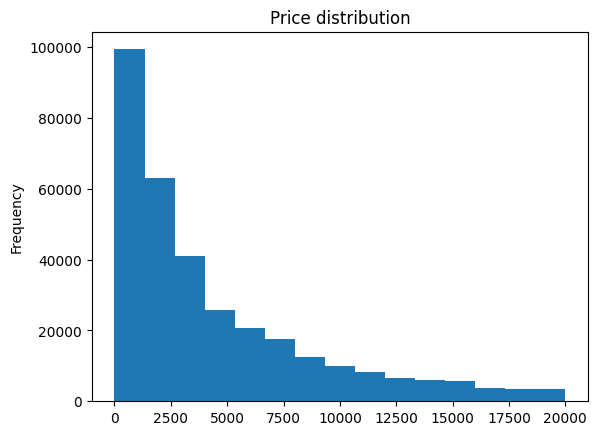

In [39]:
#Plotting the distribution of the Price data
df_cleaned['Price'].plot(kind='hist', title='Price distribution', xlabel='Price', bins = 15)
plt.show()

Here we see that the data is skewed to the right, so most of the observations have low values. How relevant is it to show the model to calculate the price of vehicles at 0 and also, is the price correct? Could it be missing data in reality? 

To explore this, I'll give a look at the observations filtering at different price brackets:

In [40]:
#Filtering data with a price of 0
zero = df_cleaned[df_cleaned['Price'] == 0]
print(zero.shape)
print(zero.shape[0] / 354369, 'of the observations have a price of 0')

(9386, 11)
0.026486515468339498 of the observations have a price of 0


About 3% of the observations have a price of 0. Now I'll call the describe method to try to spot if the price makes sense with the rest of the features.

After doing this with the next two brackets, I discovered that the price seems to be inversely proportional to the car's condition: if it needs repairs or not and the amount of power it has. 

For that reason, I'm also filtering how many observations of the ones with a price of 0, also have a 0 on Power. 

In [41]:
display(zero.describe(include='all'))
zp =zero[zero['Power']==0]
print(zp.shape[0]/zero.shape[0], 'of the observations in this range have 0 power')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
count,9386.0,9386,9386.000000,9386,9386.000000,9386,9386.000000,9386.000000,9386,9386,9386
unique,NaN,8,NaN,2,NaN,223,NaN,NaN,6,40,3
top,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,unknown
freq,NaN,3443,NaN,7991,NaN,1103,NaN,NaN,9201,2204,4458
mean,0.0,NaN,2008.705838,NaN,85.099616,NaN,125009.056041,3.874707,NaN,NaN,NaN
std,0.0,NaN,261.753969,NaN,250.015988,NaN,47290.602556,4.052278,NaN,NaN,NaN
min,0.0,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN
25%,0.0,NaN,1996.000000,NaN,0.000000,NaN,125000.000000,0.000000,NaN,NaN,NaN
50%,0.0,NaN,2000.000000,NaN,75.000000,NaN,150000.000000,3.000000,NaN,NaN,NaN
75%,0.0,NaN,2005.000000,NaN,125.000000,NaN,150000.000000,7.000000,NaN,NaN,NaN


0.3358193053483912 of the observations in this range have 0 power


Almost 36% of the observations have 0 power and 68% need repairs. 

In [42]:
#Filtering data with a price between 0 and 1000
thousand = df_cleaned[(df_cleaned['Price'] > 0) & (df_cleaned['Price'] <= 1000)]
thousand.shape
print(thousand.shape[0] / 354369, 'of the observations have a price bigger than 0 and lower than 1000')

0.20493045384895406 of the observations have a price bigger than 0 and lower than 1000


In [43]:
display(thousand.describe(include='all'))
zp =thousand[thousand['Power']==0]
print(zp.shape[0]/thousand.shape[0], 'of the observations in this range have 0 power')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
count,72621.000000,72621,72621.000000,72621,72621.000000,72621,72621.000000,72621.000000,72621,72621,72621
unique,NaN,8,NaN,2,NaN,223,NaN,NaN,6,40,3
top,NaN,small,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no
freq,NaN,30963,NaN,66470,NaN,7218,NaN,NaN,71761,15178,31370
mean,601.984908,NaN,2001.825739,NaN,73.094394,NaN,137282.535355,4.884524,NaN,NaN,NaN
std,279.570440,NaN,131.120309,NaN,166.437309,NaN,33227.566122,3.901623,NaN,NaN,NaN
min,1.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN
25%,399.000000,NaN,1996.000000,NaN,45.000000,NaN,150000.000000,1.000000,NaN,NaN,NaN
50%,600.000000,NaN,1998.000000,NaN,70.000000,NaN,150000.000000,5.000000,NaN,NaN,NaN
75%,850.000000,NaN,2001.000000,NaN,101.000000,NaN,150000.000000,8.000000,NaN,NaN,NaN


0.21186709078641164 of the observations in this range have 0 power


In [44]:
two_fh = df_cleaned[(df_cleaned['Price'] > 1000) & (df_cleaned['Price'] <= 2500)]
two_fh.shape
print(two_fh.shape[0] / 354369, 'of the observations have a price bigger than 1000 and lower than 2500')

0.21731867065121385 of the observations have a price bigger than 1000 and lower than 2500


In [45]:
display(two_fh.describe(include='all'))
zp =two_fh[two_fh['Power']==0]
print(zp.shape[0]/two_fh.shape[0], 'of the observations in this range have 0 power')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
count,77011.000000,77011,77011.000000,77011,77011.000000,77011,77011.00000,77011.000000,77011,77011,77011
unique,NaN,8,NaN,2,NaN,220,NaN,NaN,6,40,3
top,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no
freq,NaN,24940,NaN,66133,NaN,7876,NaN,NaN,75504,16783,52494
mean,1734.216735,NaN,2001.695966,NaN,95.533326,NaN,138833.54326,5.735908,NaN,NaN,NaN
std,428.745759,NaN,51.107658,NaN,216.327671,NaN,27508.59369,3.734016,NaN,NaN,NaN
min,1001.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.00000,0.000000,NaN,NaN,NaN
25%,1350.000000,NaN,1998.000000,NaN,60.000000,NaN,150000.00000,3.000000,NaN,NaN,NaN
50%,1699.000000,NaN,2001.000000,NaN,90.000000,NaN,150000.00000,6.000000,NaN,NaN,NaN
75%,2000.000000,NaN,2003.000000,NaN,120.000000,NaN,150000.00000,9.000000,NaN,NaN,NaN


0.11877523990079339 of the observations in this range have 0 power


24% of the data have a price between 1000 and 2500, out of them, only 12% have 0 power.

As expected, cars with better condition cost more, and it also seems like the 0 price is a correct price and it seems likely that this website actually prices certain vehicles at 0.

To finalize this part of the analysis, I'll create a chart categorizing the cars according to their condition, we will be able to see the amount of cars in each situation as well as their mean and median price.

In [46]:
# Creating power categories 
df_cleaned['power_category'] = pd.cut(df_cleaned['Power'], 
                             bins=[0, 0.1, 100, 200, df_cleaned['Power'].max()], 
                             labels=['Zero/Minimal', 'Low', 'Medium', 'High'],
                             include_lowest=True)

#Creating the chart
summary = df_cleaned.groupby(['NotRepaired', 'power_category']).agg({
    'Price': ['count', 'mean', 'median'],
}).round(2)

print(summary)

                             Price                 
                             count      mean median
NotRepaired power_category                         
no          Zero/Minimal     13102   3129.44   1750
            Low              73284   2999.79   1990
            Medium          122726   6154.63   4800
            High             16854  10717.07  10500
unknown     Zero/Minimal     19290   1832.26    895
            Low              21073   1638.11    990
            Medium           23375   3711.49   2490
            High              2685   7372.27   6700
yes         Zero/Minimal      4642   1124.99    500
            Low              12609   1109.79    600
            Medium           15643   2436.82   1390
            High              1535   5657.81   4500


Here we can see clearly, how the price increases when the car has more power and doesn't need repairs. A new column was created dividing the power in brackets.

It also shows how most of the cars don't need repairs and have medium power. Also, the most expensive ones are the ones that don't need repairs and have high power, followed by the ones that need repairs and also have high power. 

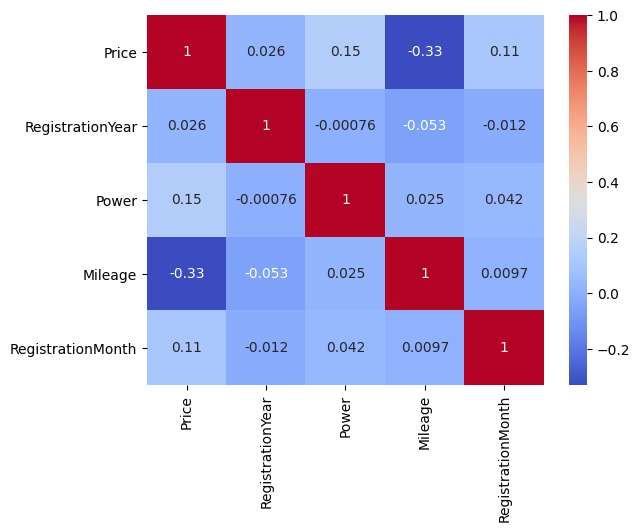

In [47]:
#Generating a correlation matrix
correlation_matrix = df_cleaned.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

The correlation matrix confirms the correlation between price and power, it is also pointing towards the fact that the mileage has an inverse relationship with price.

On a second phase of working with the project, it was decided that it was best to remove data with a price of 0 since it only represents 2.6% of the data. After dropping the rows with a price of 0, there were still cars with a price of 1. I decided then to define the values to drop using the quantiles method. By dropping 5% of the data on the lower end, the minimum price for the cars is at 202. 

In [48]:
# Calculating the 2.5th percentile of the column
lower_threshold = df_cleaned['Price'].quantile(0.05)

# Filtering the DataFrame to keep only rows where the column value is greater than the lower threshold
df_cleaned= df_cleaned[df_cleaned['Price'] > lower_threshold] 

#Calling the describe method to confirm what our minimum values are now.
df_cleaned.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth
count,309178.000000,309178.000000,309178.000000,309178.000000,309178.000000
mean,4651.763945,2003.980458,112.430283,128336.023262,5.807250
std,4521.008347,69.362589,193.040183,37273.423802,3.677885
min,202.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1250.000000,1999.000000,72.000000,125000.000000,3.000000
50%,2950.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6650.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


## Power

The power values seem worrying, the values seem to go unrealistically high. I did a little research, and no car can have more than 1000 hp, and that is a very extreme case. So any number above it, is not realistic. I'm going to filter the observations that have a higher power than that to try to understand the situation. 

In [49]:
#Filtering rows with high power
high_power = df_cleaned[df_cleaned['Power'] > 1000]
#Applying the describe method
display(high_power.describe(include = 'all'))
#Obtaining the volume of data these rows represent
print(high_power.shape[0] / 354369, 'of the observations have an unrealistic power value of over 1000')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,power_category
count,270.000000,270,270.000000,270,270.000000,270,270.000000,270.000000,270,270,270,270
unique,NaN,8,NaN,2,NaN,81,NaN,NaN,4,28,3,1
top,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,High
freq,NaN,93,NaN,211,NaN,21,NaN,NaN,264,62,140,270
mean,3334.659259,NaN,1998.066667,NaN,4168.822222,NaN,126037.037037,5.833333,NaN,NaN,NaN,NaN
std,3409.463967,NaN,46.304584,NaN,4657.823012,NaN,44274.810516,3.948319,NaN,NaN,NaN,NaN
min,220.000000,NaN,1400.000000,NaN,1001.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN
25%,1000.000000,NaN,1998.000000,NaN,1372.750000,NaN,125000.000000,2.000000,NaN,NaN,NaN,NaN
50%,1947.500000,NaN,2002.000000,NaN,1800.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN
75%,4500.000000,NaN,2006.000000,NaN,6009.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN


0.0007619176620979826 of the observations have an unrealistic power value of over 1000


<AxesSubplot:title={'center':'Cars with more than 1000 power'}, ylabel='Frequency'>

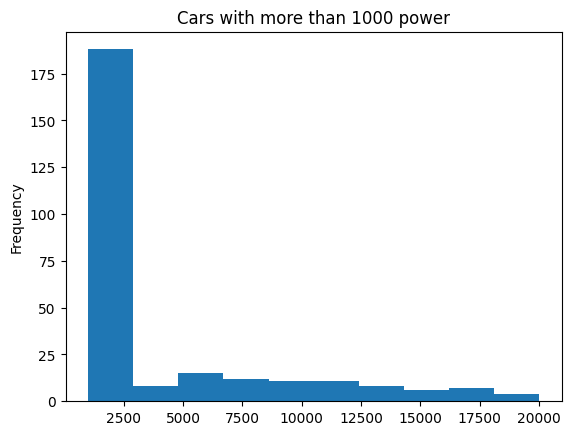

In [50]:
#Looking at the distribution of power in the rows with more than 1000
high_power['Power'].plot(kind='hist', title='Cars with more than 1000 power')

Now we are going to do the same thing but with rows that have less than 1000 power, to be able to compare them.

In [51]:
#Filtering rows with less equal or less than 1000 power
regular_power = df_cleaned[df_cleaned['Power'] <= 1000]
#Applying the describe method
regular_power.describe(include = 'all')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,power_category
count,308908.000000,308908,308908.000000,308908,308908.000000,308908,308908.000000,308908.000000,308908,308908,308908,308908
unique,NaN,8,NaN,2,NaN,251,NaN,NaN,6,40,3,4
top,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,Medium
freq,NaN,94948,NaN,248170,NaN,27850,NaN,NaN,303189,66065,221228,157421
mean,4652.915156,NaN,2003.985627,NaN,108.884807,NaN,128338.032683,5.807227,NaN,NaN,NaN,NaN
std,4521.696730,NaN,69.379221,NaN,63.325200,NaN,37266.752003,3.677647,NaN,NaN,NaN,NaN
min,202.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN
25%,1250.000000,NaN,1999.000000,NaN,72.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN
50%,2950.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN
75%,6650.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Cars with less than 1000 power'}, ylabel='Frequency'>

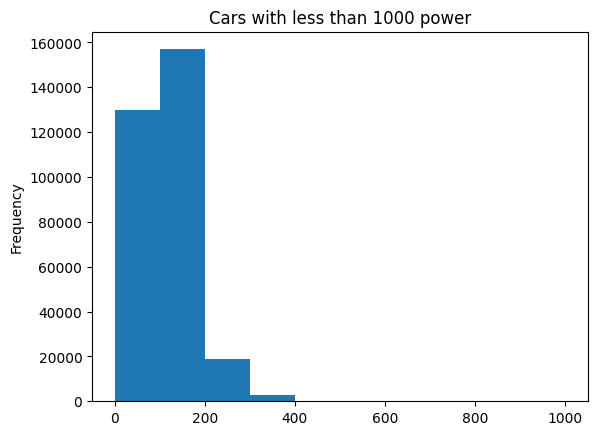

In [52]:
#Plotting distribution of the power feature in rows with equal or less than 1000 power
regular_power['Power'].plot(kind='hist', title='Cars with less than 1000 power')

By filtering the values and comparing them we encountered the following: 
- The mean price for power values over 1000 is lower than the price for the rest of the values.
- Top values for features like VehicleType, Gearbox, Model, and Brand, are the same for both rows with higher and lower than 1000 in power.
This is pointing to the conclusion that this data is corrupted. According to our analysis, higher power tends to mean a higher price. But that is not happening here. Also, if the higher power values were correct, we would be seing different brands than for the rest of the dataset. Due to this and the fact that we only have 295 rows with this problem (less than 1% of the data), we are going to be discarding them for building the model since it would make it harder for the model to understand the relevance of the power value in the price definition.


In [53]:
#Filtering rows with power higher than 1000
df_cleaned = df_cleaned[(df_cleaned['Power'] <= 1000)]

## Registration Year

I have previously called the describe method on previous occasions, and it seems like there are cars with unrealistic years, both after 2025 and before the 1900. We will do some exploration to define how to handle this matter.

First I'm going to filter all the observations with obviously wrong dates. Over 2025 and before 1900:

In [54]:
#Plotting the distribution of the RegistrationYear data
out_ry = df_cleaned[(df_cleaned['RegistrationYear'] > 2025) | (df_cleaned['RegistrationYear'] < 1900)]
out_ry.describe(include='all')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,power_category
count,93.000000,93,93.000000,93,93.000000,93,93.000000,93.000000,93,93,93,93
unique,NaN,5,NaN,2,NaN,29,NaN,NaN,3,17,3,4
top,NaN,sedan,NaN,manual,NaN,NA,NaN,NaN,petrol,volkswagen,unknown,Zero/Minimal
freq,NaN,72,NaN,85,NaN,21,NaN,NaN,91,24,80,68
mean,4127.720430,NaN,4419.978495,NaN,50.075269,NaN,6666.666667,1.172043,NaN,NaN,NaN,NaN
std,4979.423717,NaN,3174.594253,NaN,139.521795,NaN,2369.797888,2.764777,NaN,NaN,NaN,NaN
min,250.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN
25%,500.000000,NaN,1234.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN
50%,1550.000000,NaN,4000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN
75%,6500.000000,NaN,6000.000000,NaN,13.000000,NaN,10000.000000,0.000000,NaN,NaN,NaN,NaN


There are 171 observtions with unrealistic years. I'm going to get rid of these values since they are not even 1% of the data.

The most complicated part is deciding where to draw the line for old cars. Technically, it is possible to have cars from after 1900, but early 1900 would be classic or antique cars. I'll proceed with discarding the 171 observations and then I will obtain the year distribution to get an idea of the general client of the website. Because the name certainly doesn't seem to point to an antique car-selling platform:

In [55]:
#Filtering rows with unrealistic car years:
df_cleaned = df_cleaned[(df_cleaned['RegistrationYear'] > 1900) & (df_cleaned['RegistrationYear'] < 2026)]
df_cleaned.shape

(308815, 12)

I did a first histogram that I'm not included and realized that most of the observations are concentrated after 1980. So I'm creating two plots, one after 1980, and one before, to be able to decide if I'm putting a limit to the year.

<AxesSubplot:title={'center':'Cars 1960+'}, ylabel='Frequency'>

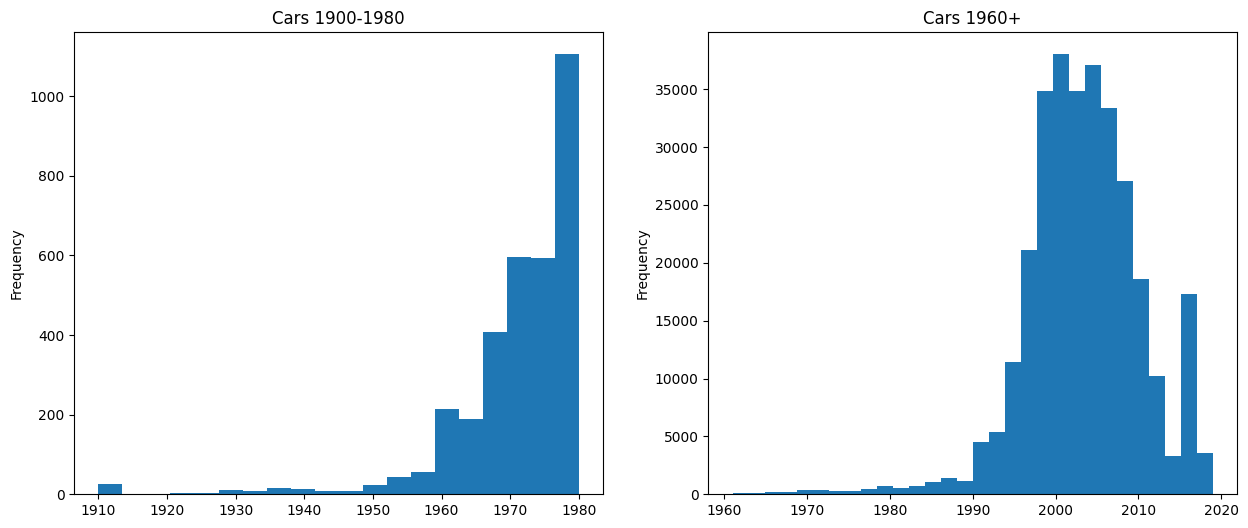

In [56]:
# Creating separate plots for different time periods
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Very old cars (1900-1980)
old_cars = df_cleaned[df_cleaned['RegistrationYear'] <= 1980]
old_cars['RegistrationYear'].plot(kind='hist', ax=axes[0], bins=20, title='Cars 1900-1980')

# Plot 2: Modern cars (1960+)
modern_cars = df_cleaned[df_cleaned['RegistrationYear'] > 1960]
modern_cars['RegistrationYear'].plot(kind='hist', ax=axes[1], bins=30, title='Cars 1960+')

In [57]:
modern_cars = modern_cars['RegistrationYear'].value_counts().sort_index()
print("Cars registered from 1960 and on")
print(modern_cars.head(40))

Cars registered from 1960 and on
1961       34
1962       39
1963       54
1964       58
1965       78
1966      107
1967       93
1968       97
1969      110
1970      237
1971      157
1972      202
1973      158
1974      158
1975      132
1976      146
1977      159
1978      258
1979      254
1980      434
1981      233
1982      292
1983      374
1984      364
1985      601
1986      466
1987      584
1988      845
1989     1127
1990     2151
1991     2348
1992     2527
1993     2869
1994     4017
1995     7443
1996     8940
1997    12169
1998    15198
1999    19634
2000    20111
Name: RegistrationYear, dtype: int64


After seing these distribution plots, I am feeling enclined to discard all data from before 1950. But I'm going to study the situation a little further before making a decision. In this next step I'm going to focus on the distribution of years before 1950:

In [58]:
# Look at exact counts for very old cars
very_old = df_cleaned[df_cleaned['RegistrationYear'] <= 1960]
very_old_y = very_old['RegistrationYear'].value_counts().sort_index()
print("Cars registered 1900-1950:")
print(very_old_y.head(40))

Cars registered 1900-1950:
1910     25
1923      2
1925      1
1927      1
1928      2
1929      6
1930      2
1931      1
1932      3
1933      2
1934      2
1935      3
1936      3
1937     10
1938      8
1940      2
1941      2
1942      2
1943      4
1944      2
1945      4
1946      1
1947      2
1948      2
1949      1
1950     13
1951     10
1952      8
1953     14
1954      9
1955     13
1956     24
1957     13
1958     19
1959     28
1960    112
Name: RegistrationYear, dtype: int64


There is a peak of entries at year 1910, why specifically 1910? Are these cars different from the rest of this bracket?

In [59]:
#Looking at data for 1910 cars
ten = df_cleaned[df_cleaned['RegistrationYear'] == 1910]
ten.describe(include='all')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,power_category
count,25.000000,25,25.0,25,25.000000,25,25.000000,25.000000,25,25,25,25
unique,NaN,5,NaN,1,NaN,14,NaN,NaN,1,8,3,4
top,NaN,sedan,NaN,manual,NaN,NA,NaN,NaN,petrol,volkswagen,unknown,Zero/Minimal
freq,NaN,13,NaN,25,NaN,5,NaN,NaN,25,7,22,19
mean,1203.640000,NaN,1910.0,NaN,58.760000,NaN,72200.000000,0.680000,NaN,NaN,NaN,NaN
std,1276.963419,NaN,0.0,NaN,200.414421,NaN,72342.933311,1.994158,NaN,NaN,NaN,NaN
min,220.000000,NaN,1910.0,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN
25%,400.000000,NaN,1910.0,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN
50%,599.000000,NaN,1910.0,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN
75%,1300.000000,NaN,1910.0,NaN,0.000000,NaN,150000.000000,0.000000,NaN,NaN,NaN,NaN


The vast majority of these cars are priced at 0 and have no power. It seems likely that the year 1910 is only a random value for cars with no clear year.

In [60]:
#Looking at data for cars between 1911 and 1949
fifty = df_cleaned[(df_cleaned['RegistrationYear'] <= 1950) & (df_cleaned['RegistrationYear'] > 1910)]
fifty.describe(include='all')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,power_category
count,81.000000,81,81.000000,81,81.000000,81,81.000000,81.000000,81,81,81,81
unique,NaN,7,NaN,2,NaN,9,NaN,NaN,2,13,3,4
top,NaN,sedan,NaN,manual,NaN,other,NaN,NaN,petrol,sonstige_autos,no,Low
freq,NaN,25,NaN,78,NaN,46,NaN,NaN,80,26,40,40
mean,10097.975309,NaN,1938.975309,NaN,39.913580,NaN,56851.851852,3.444444,NaN,NaN,NaN,NaN
std,5450.794749,NaN,7.591073,NaN,114.761622,NaN,57104.314879,3.205464,NaN,NaN,NaN,NaN
min,500.000000,NaN,1923.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN
25%,5900.000000,NaN,1934.000000,NaN,0.000000,NaN,5000.000000,1.000000,NaN,NaN,NaN,NaN
50%,9500.000000,NaN,1938.000000,NaN,15.000000,NaN,30000.000000,2.000000,NaN,NaN,NaN,NaN
75%,14500.000000,NaN,1945.000000,NaN,40.000000,NaN,100000.000000,6.000000,NaN,NaN,NaN,NaN


We only have 97 cars in this category. They do have some value, and the amount of them that need repairs is less. However, it seems like the price distribution might be too wide. We are probably looking at both very old cars with no value and real antique/classic vehicles. With so little amount of entries and such a wide price distribution. It would be hard for the model to learn how to price these vehicles, plus, antique cars are not really the market target for this web page. 

<AxesSubplot:title={'center':'Cars 1911-1949'}, ylabel='Frequency'>

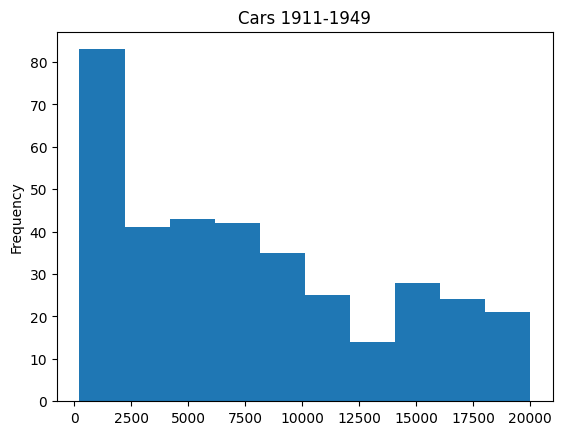

In [61]:
#Looking at the price distribution for cars between 1911 and 1949
very_old['Price'].plot(kind='hist', title='Cars 1911-1949')

It was confirmed that the price distribution is too spread. For the model, I will only be considering cars from 1950 and on, since we don't have enough data for cars older than that.

On a second phase of the project, it was defined that given that cars from 1950 are over 6 standard deviations from the mean of 2003, it would be best to narrow the registration year further. In this case, I will be considering 3 standard deviations of 8, leaving us with cars from 1979 and on. 

In [62]:
#Filtering the dataset to contain only observations from 1979 and on:
df_cleaned = df_cleaned[(df_cleaned['RegistrationYear'] > 1978)]
display(df_cleaned.describe())

,Price,RegistrationYear,Power,Mileage,RegistrationMonth
count,306182.000000,306182.000000,306182.000000,306182.000000,306182.000000
mean,4625.462029,2003.555317,109.226029,128745.354070,5.818902
std,4502.432799,6.589693,62.999792,36848.329663,3.677408
min,202.000000,1979.000000,0.000000,5000.000000,0.000000
25%,1250.000000,1999.000000,74.000000,125000.000000,3.000000
50%,2950.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6550.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,2019.000000,1000.000000,150000.000000,12.000000


## Registration Month

On this section we are going to approach the question of wether the RegistrationMonth feature is relevant for the model. First, we are going to check for the correlation between price and registration month.

In [63]:
#Obtaining the correlation between the price and registration month
correlation_1_2 = df_cleaned['Price'].corr(df_cleaned['RegistrationMonth'])
print(f"Correlation between price and registration month is: {correlation_1_2}")

Correlation between price and registration month is: 0.08676413847513856


There is a 0.11 correlation between price and registration month. It is showing at least a weak correlation. This is pointing to say that we should keep the feature. 

I am interested in checking why we have 13 month unique values, when there are only 12 months. To try to arrive at some conclusions, I will obtain the mean price value for each month:

In [64]:
#Obtaining the mean price per month value
rm = df_cleaned.groupby('RegistrationMonth')['Price'].mean()
display(rm)

RegistrationMonth
0     2363.432696
1     4844.396100
2     4744.135193
3     4705.545602
4     4904.791163
5     4786.498518
6     4828.164257
7     4872.087792
8     4803.543401
9     5005.942735
10    4949.367094
11    5010.251131
12    4760.373782
Name: Price, dtype: float64

The mean price stays similar in most months, except for month 0. This is pointing to the possibility that even when month 0 doesn't exist, it is represeting missing data. So it is relevant to the model. To confirm this I'll apply the describe method only to the rows with month 0 value:

In [65]:
#Filtering rows with a 0 month value
mz = df_cleaned[(df_cleaned['RegistrationMonth']==0)]
display(mz.describe(include='all'))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,power_category
count,27398.000000,27398,27398.000000,27398,27398.000000,27398,27398.000000,27398.0,27398,27398,27398,27398
unique,NaN,8,NaN,2,NaN,236,NaN,NaN,6,40,3,4
top,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,unknown,Zero/Minimal
freq,NaN,9440,NaN,23693,NaN,3364,NaN,NaN,26984,6652,15306,9647
mean,2363.432696,NaN,2002.630849,NaN,72.469377,NaN,132555.843492,0.0,NaN,NaN,NaN,NaN
std,2896.332798,NaN,8.424628,NaN,68.502822,NaN,38561.645150,0.0,NaN,NaN,NaN,NaN
min,205.000000,NaN,1979.000000,NaN,0.000000,NaN,5000.000000,0.0,NaN,NaN,NaN,NaN
25%,650.000000,NaN,1997.000000,NaN,0.000000,NaN,150000.000000,0.0,NaN,NaN,NaN,NaN
50%,1299.000000,NaN,2000.000000,NaN,75.000000,NaN,150000.000000,0.0,NaN,NaN,NaN,NaN
75%,2800.000000,NaN,2007.000000,NaN,116.000000,NaN,150000.000000,0.0,NaN,NaN,NaN,NaN


The mean price for entries with month 0 is low, also they tend to need repairs and have a very low power. Also, we have 37086 rows with this value. These rows can't be discarded because they are a good % of the data. And it does seem to be relevant.

I had also considered mixing the year and month feature in one feature only, however, the 0 month values would either be lost of lose the information. For this reason I will be keeping the feature and leave it as an independent one.

----In a second phase of the project, it was decided that after some consideration, the information for observations with a registration month at 0 is not relevant for the model, so those rows will be discarded:

In [66]:
#Discarding rows with a RegistrationMonth of 0
df_cleaned = df_cleaned[(df_cleaned['RegistrationMonth'] > 0)]
display(df_cleaned.describe())

,Price,RegistrationYear,Power,Mileage,RegistrationMonth
count,278784.000000,278784.000000,278784.000000,278784.000000,278784.000000
mean,4847.767038,2003.646171,112.838355,128370.871356,6.390765
std,4570.283596,6.373735,61.253936,36654.331438,3.346298
min,202.000000,1979.000000,0.000000,5000.000000,1.000000
25%,1399.000000,1999.000000,75.000000,125000.000000,4.000000
50%,3199.000000,2004.000000,107.000000,150000.000000,6.000000
75%,6950.000000,2008.000000,144.000000,150000.000000,9.000000
max,20000.000000,2019.000000,1000.000000,150000.000000,12.000000


## Mileage

It has cought my attention that many entries seem to have 150000 miles specifically. I also have the impression that we are not dealing with continues values, but that they are grouped by certain numbers. My hypothesis is that if it is not a continous variable, we might be able to divide the data in categories. We'll start by plotting the distribution of the data:

<function matplotlib.pyplot.show(close=None, block=None)>

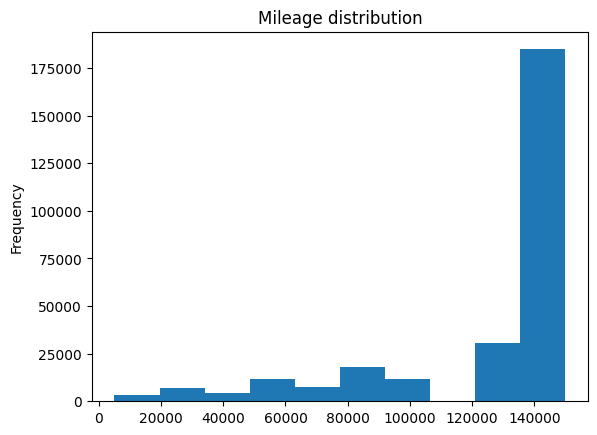

In [67]:
#Plotting the distribution of the mileage feature
df_cleaned['Mileage'].plot(kind='hist', title='Mileage distribution')
plt.show

In [68]:
df_cleaned['Mileage'].value_counts()

150000    184812
125000     30339
100000     11959
90000       9711
80000       8500
70000       7431
60000       6278
50000       5316
40000       4207
30000       3632
20000       3097
5000        2634
10000        868
Name: Mileage, dtype: int64

As expected, we are not dealing with a continuos variable, however, I won't be creating categories because there might be a relation between price and mileage that I don't fully understand yet and it might be lost if I create brackets without considering it.

Finally, the power category row, is not going to be used for the model training, for the same reasons that we are not creating categories from the mileage. I'll be dropping it in the next step.

In [69]:
#Dropping the 'power_category' feature
df_cleaned = df_cleaned.drop('power_category', axis = 1)
df_cleaned.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,a4,125000,5,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


In [70]:
#Calling the describe method for a final check
df_cleaned.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth
count,278784.000000,278784.000000,278784.000000,278784.000000,278784.000000
mean,4847.767038,2003.646171,112.838355,128370.871356,6.390765
std,4570.283596,6.373735,61.253936,36654.331438,3.346298
min,202.000000,1979.000000,0.000000,5000.000000,1.000000
25%,1399.000000,1999.000000,75.000000,125000.000000,4.000000
50%,3199.000000,2004.000000,107.000000,150000.000000,6.000000
75%,6950.000000,2008.000000,144.000000,150000.000000,9.000000
max,20000.000000,2019.000000,1000.000000,150000.000000,12.000000


## Model training

Before moving forward with training the models, we need to do some final adjustments: encoding categorial features, splitting the data into the training, validation and test sets, and finally standardizing the data.

Originally I was applying the One Hot Encoding to all of the features, but this was creating too many rows and the system was crashing. For this reason, I decided to apply ordinal encoding to the features with the bigger amount of unique values, in order to prevent the creation of too many columns. In this case the ordinal encoding was applied to the Model and Brand features. The rest of the categorical features were encoded with the One Hot Encoder. All of the models will be trained with the data that is already encoded, so that we can compare the results having the same information as the base. 

In [71]:
#Splitting the data into training (60%), validation (20%) and testing (20%)
features = df_cleaned.drop('Price', axis=1)
target = df_cleaned['Price'] 
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345) 
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.25, random_state=12345) 

In [72]:
#Applying ordinal encoding to the Model and Brand features
columns_to_encode = ['Model', 'Brand']
# Initializing and applying OrdinalEncoder for each column
features_train_encoded = features_train
features_valid_encoded = features_valid
for col in columns_to_encode:
    encoder = OrdinalEncoder() 
    features_train_encoded[col] = encoder.fit_transform(features_train_encoded[[col]]) 
    features_valid_encoded[col] = encoder.fit_transform(features_valid_encoded[[col]]) 
display(features_train_encoded.head(10))
features_train_encoded.info()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
40019,small,2005,manual,90,117.0,150000,5,petrol,38.0,unknown
110073,sedan,2006,auto,231,96.0,125000,10,petrol,20.0,no
67440,sedan,2017,manual,101,117.0,150000,6,petrol,38.0,no
74259,sedan,2006,manual,0,11.0,150000,11,petrol,2.0,unknown
80118,coupe,1998,auto,75,43.0,150000,9,petrol,24.0,unknown
314988,sedan,2017,manual,110,10.0,125000,11,petrol,25.0,no
1504,small,2004,manual,102,50.0,90000,2,petrol,38.0,no
322645,coupe,2010,manual,184,11.0,80000,7,petrol,2.0,no
208556,sedan,2018,manual,0,11.0,150000,3,petrol,2.0,unknown
272965,sedan,2002,manual,105,2.0,125000,2,petrol,0.0,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 167270 entries, 40019 to 184283
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   VehicleType        167270 non-null  object 
 1   RegistrationYear   167270 non-null  int64  
 2   Gearbox            167270 non-null  object 
 3   Power              167270 non-null  int64  
 4   Model              167270 non-null  float64
 5   Mileage            167270 non-null  int64  
 6   RegistrationMonth  167270 non-null  int64  
 7   FuelType           167270 non-null  object 
 8   Brand              167270 non-null  float64
 9   NotRepaired        167270 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 14.0+ MB


In [73]:
#Applying one hot ecoding to the rest of the categorical features
encoded = ['Model', 'Brand']
categoric = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']
numeric = ['RegistrationYear', 'Power', 'Mileage', 'RegistrationMonth']

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

features_enc_train = encoder.fit_transform(features_train_encoded[categoric])

features_enc_df_train = pd.DataFrame(features_enc_train, columns=encoder.get_feature_names(categoric)) 

features_enc_df_train.index = features_train_encoded.index 

features_train_encoded = pd.concat([features_enc_df_train, features_train_encoded[encoded], features_train_encoded[numeric]], axis=1)
display(features_train_encoded.head(10))

,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_auto,Gearbox_manual,...,FuelType_petrol,NotRepaired_no,NotRepaired_unknown,NotRepaired_yes,Model,Brand,RegistrationYear,Power,Mileage,RegistrationMonth
40019,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,117.0,38.0,2005,90,150000,5
110073,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,96.0,20.0,2006,231,125000,10
67440,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,117.0,38.0,2017,101,150000,6
74259,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,11.0,2.0,2006,0,150000,11
80118,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,43.0,24.0,1998,75,150000,9
314988,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,10.0,25.0,2017,110,125000,11
1504,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,50.0,38.0,2004,102,90000,2
322645,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,11.0,2.0,2010,184,80000,7
208556,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,11.0,2.0,2018,0,150000,3
272965,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,2.0,0.0,2002,105,125000,2


In [74]:
features_enc_valid = encoder.fit_transform(features_valid_encoded[categoric])

features_enc_df_valid = pd.DataFrame(features_enc_valid, columns=encoder.get_feature_names(categoric)) 

features_enc_df_valid.index = features_valid_encoded.index 

features_valid_encoded = pd.concat([features_enc_df_valid, features_valid_encoded[encoded], features_valid_encoded[numeric]], axis=1)
features_valid_encoded.head(10)

,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_auto,Gearbox_manual,...,FuelType_petrol,NotRepaired_no,NotRepaired_unknown,NotRepaired_yes,Model,Brand,RegistrationYear,Power,Mileage,RegistrationMonth
88172,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,128.0,10.0,1997,60,150000,6
106971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,30.0,1.0,2000,150,150000,10
149080,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,105.0,32.0,2005,95,50000,6
273333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,54.0,9.0,2000,80,150000,5
102227,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,119.0,12.0,2010,109,40000,11
171950,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,43.0,24.0,2004,80,150000,5
192012,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,228.0,24.0,2002,125,150000,3
210697,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,101.0,31.0,2000,75,150000,9
108875,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,15.0,2.0,1997,235,150000,10
143881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,11.0,2.0,2008,170,150000,3


In [75]:
#Getting a glimpse at the info for the final dataframe after encoding
print(features_train_encoded.info())
print(features_valid_encoded.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167270 entries, 40019 to 184283
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   VehicleType_bus          167270 non-null  float64
 1   VehicleType_convertible  167270 non-null  float64
 2   VehicleType_coupe        167270 non-null  float64
 3   VehicleType_other        167270 non-null  float64
 4   VehicleType_sedan        167270 non-null  float64
 5   VehicleType_small        167270 non-null  float64
 6   VehicleType_suv          167270 non-null  float64
 7   VehicleType_wagon        167270 non-null  float64
 8   Gearbox_auto             167270 non-null  float64
 9   Gearbox_manual           167270 non-null  float64
 10  FuelType_cng             167270 non-null  float64
 11  FuelType_electric        167270 non-null  float64
 12  FuelType_hybrid          167270 non-null  float64
 13  FuelType_lpg             167270 non-null  float64
 14  

In [76]:
#Scaling the data 
scaler = StandardScaler() 
features_train_encoded = scaler.fit_transform(features_train_encoded)
features_valid_encoded = scaler.transform(features_valid_encoded)

## Linear Regression Model

First we will train a Linear regression model that will serve as a reference for the performance of the following models.

In [77]:
#Dropping the model and brand features due to too many unique values that create an overly large dataframe when using OneHotEncoding
# Specify the indices of the columns to delete (e.g., column at index 1 and 3)
columns_to_delete = [20, 21]

# Delete the specified columns 
features_train_encoded_lr = np.delete(features_train_encoded, columns_to_delete, axis=1)
features_valid_encoded_lr = np.delete(features_valid_encoded, columns_to_delete, axis=1)

In [78]:
#Training a regular linear regression model
lr = LinearRegression()

start_time = time.time()
lr.fit(features_train_encoded_lr, target_train) 
end_time= time.time()
print(f"Linear regression execution time on training set: {(end_time - start_time):.2f}")

start_time = time.time()
pred_valid = lr.predict(features_valid_encoded_lr) 
end_time= time.time()
print(f"Linear regression execution time on validation set: {(end_time - start_time):.2f}")

score= (np.sqrt(mse(target_valid, pred_valid)))
      
print("Score of the linear regression model on the validation set:", score)

Linear regression execution time on training set: 0.06
Linear regression execution time on validation set: 0.01
Score of the linear regression model on the validation set: 3341.424125268819


## Random Forest Model

Now we will train a Random Forest model while tuning the hyperparamenters to find the best parameters:

In [79]:
#Training a random forest regressor
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for depth in range (1, 11, 2):
    for est in range(10, 100, 10):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        start_time_train = time.time()
        model.fit(features_train_encoded, target_train) 
        end_time_train = time.time()
        
        start_time_predict = time.time()
        pred_valid = model.predict(features_valid_encoded) 
        end_time_predict = time.time()
        score= np.sqrt(mse(target_valid, pred_valid))
      
        if score < best_result:
            best_model = model
            best_result = score
            best_est = est
            best_depth = depth
            training_time = end_time_train - start_time_train
            prediction_time = end_time_predict - start_time_predict

print("Score of the best model on the validation set:", best_result, "n_estimators:", best_est, "max_depth:", best_depth)
print(f"Random Forest training speed on training set: {training_time:.2f}")
print(f"Random Forest prediction speed on validation set: {prediction_time:.2f}")

Score of the best model on the validation set: 1980.4904592569724 n_estimators: 80 max_depth: 9
Random Forest training speed on training set: 18.83
Random Forest prediction speed on validation set: 0.27


The score obtained with the Random forest model is considerably better than the one we got with the linear regression.

## LGBMRegressor model

Training a LGBM Regressor model

In [80]:
#Defining the parameters grid
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 100,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1 # Suppress verbose output
}
#Training the model
model = lgb.LGBMRegressor(**params)
start_time = time.time()
model.fit(features_train_encoded, target_train)
end_time= time.time()
print(f"LGBM  training execution time: {(end_time - start_time):.2f}")

#Applying the model to the validation set
start_time = time.time()
pred_valid = model.predict(features_valid_encoded)
end_time= time.time()
rmse = mse(target_valid, pred_valid, squared=False)
print(f"LGBM execution time on the validation set: {(end_time - start_time):.2f}")

print(f"RMSE on the validation set: {rmse:.4f}")

LGBM  training execution time: 1.71
LGBM execution time on the validation set: 0.21
RMSE on the validation set: 1826.8468


## CatBoostRegressor Model

In this section we will see three different applications of the CatBoosRegressor Model. First a basic one, then one tunning the parameters with GridSearch and Finally another one tunning with RandomizedSearch CV. To be able to compare the results. 

In [81]:
# Initializing the CatBoostRegressor with RMSE as the loss function

model_cb = CatBoostRegressor(loss_function='RMSE')

# Fit the model on the training data with verbose logging every 100 iterations
start_time = time.time()
model_cb.fit(features_train_encoded, target_train, verbose=100)
end_time= time.time()
print(f"CatBoost training execution time: {(end_time - start_time):.2f}")

# Generating predictions on the training and validation sets using the trained 'model'
start_time = time.time()
pred_train = model_cb.predict(features_train_encoded)
end_time= time.time()
print(f"CatBoostRegressor prediction time on the training set: {(end_time - start_time):.2f}")

start_time = time.time()
pred_valid = model_cb.predict(features_valid_encoded)
end_time= time.time()
print(f"CatBoostRegressor prediction time on the validation set: {(end_time - start_time):.2f}")

# Calculate and print the Root Mean Squared Error (RMSE) for training and validation sets
print("Training RMSE: ", np.sqrt(mse(target_train, pred_train)))
print("Validation RMSE: ", np.sqrt(mse(target_valid, pred_valid)))

Learning rate set to 0.091935
0:	learn: 4296.4102757	total: 57.7ms	remaining: 57.6s
100:	learn: 1828.5530379	total: 986ms	remaining: 8.78s
200:	learn: 1736.2981840	total: 1.88s	remaining: 7.46s
300:	learn: 1688.6864940	total: 2.78s	remaining: 6.46s
400:	learn: 1656.6166428	total: 3.67s	remaining: 5.48s
500:	learn: 1632.0981775	total: 4.55s	remaining: 4.53s
600:	learn: 1611.9086800	total: 5.45s	remaining: 3.62s
700:	learn: 1595.2586658	total: 6.36s	remaining: 2.71s
800:	learn: 1581.1493617	total: 7.23s	remaining: 1.79s
900:	learn: 1567.7016219	total: 8.11s	remaining: 891ms
999:	learn: 1555.5487087	total: 8.97s	remaining: 0us
CatBoost training execution time: 9.25
CatBoostRegressor prediction time on the training set: 0.07
CatBoostRegressor prediction time on the validation set: 0.02
Training RMSE:  1555.5487087053043
Validation RMSE:  1679.7662408584772


In [82]:
#Tunning with GridSearchCV

model = CatBoostRegressor(verbose=0)
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.1],
    'iterations': [100, 200],
    'metric_period': [50, 100],
    'random_seed': [42]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=3)
start_time = time.time()
grid_search.fit(features_train_encoded, target_train)
end_time= time.time()
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best RMSE on training set:", -best_score)
print(f"CatBoostRegressor training time with GridSearchCV on training set: {(end_time - start_time):.2f}")

Best Parameters: {'depth': 8, 'iterations': 200, 'learning_rate': 0.1, 'metric_period': 50, 'random_seed': 42}
Best RMSE on training set: 1705.476283185055
CatBoostRegressor training time with GridSearchCV on training set: 73.39


In [83]:
#Applying the best parameters from the GridSearchCV on the CatBoostRegressor, to the validation set
start_time = time.time()
pred_valid = best_model.predict(features_valid_encoded)
end_time= time.time()
print(f"CatBoostRegressor prediction time with GridSearchCV on validation set: {(end_time - start_time):.2f}")
print("Validation RMSE: ", np.sqrt(mse(target_valid, pred_valid)))

CatBoostRegressor prediction time with GridSearchCV on validation set: 0.01
Validation RMSE:  1721.297973081411


In [84]:
#Tunning with RandomizedSearchCV
#Defining the parameter grid

param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.1],
    'iterations': [100, 200],
    'metric_period': [50, 100],
    'random_seed': [42]
}
#Initializing the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=CatBoostRegressor(),
    param_distributions=param_grid,
    n_iter=100,  
    cv=5,      
    scoring='neg_mean_squared_error',
    random_state=42, 
    n_jobs=-1    
)
start_time = time.time()
random_search.fit(features_train_encoded, target_train)
end_time= time.time()
pred_train = random_search.predict(features_train_encoded)
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Model:", best_model)
print("Best Parameters:", best_params)
print("Best RMSE:", -best_score)
print("Training RMSE: ", np.sqrt(mse(target_train, pred_train)))
print(f"CatBoostRegressor training time with RandomizedSearchCV on training set: {(end_time - start_time):.2f}")

/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0:	learn: 4264.7154611	total: 14ms	remaining: 2.79s
50:	learn: 1850.0862240	total: 566ms	remaining: 1.65s
100:	learn: 1742.0955511	total: 1.11s	remaining: 1.09s
150:	learn: 1687.8597110	total: 1.65s	remaining: 534ms
199:	learn: 1652.5413744	total: 2.17s	remaining: 0us
Best Model: <catboost.core.CatBoostRegressor object at 0x7f1f5952cf10>
Best Parameters: {'random_seed': 42, 'metric_period': 50, 'learning_rate': 0.1, 'iterations': 200, 'depth': 8}
Best RMSE: 2893593.8099693405
Training RMSE:  1652.5413743535555
CatBoostRegressor training time with RandomizedSearchCV on training set: 110.42


In [85]:
#Applying the best parameters from the RandomizedSearchCV on the CatBoostRegressor, to the validation set
start_time = time.time()
pred_valid = best_model.predict(features_valid_encoded)
end_time= time.time()
print(f"CatBoostRegressor prediction time with RandomizedSearchCV on validation set: {(end_time - start_time):.2f}")
print("Validation RMSE: ", np.sqrt(mse(target_valid, pred_valid)))

CatBoostRegressor prediction time with RandomizedSearchCV on validation set: 0.01
Validation RMSE:  1721.297973081411


After applying two different tunning methods, the results obtained by the CatBoostRegressor on its own, where the best. 

## XGBoost Model

XGBoost training time on training set: 16.98
XGBoost prediction time on validation set: 0.02
RMSE on validation set: 1773.2430


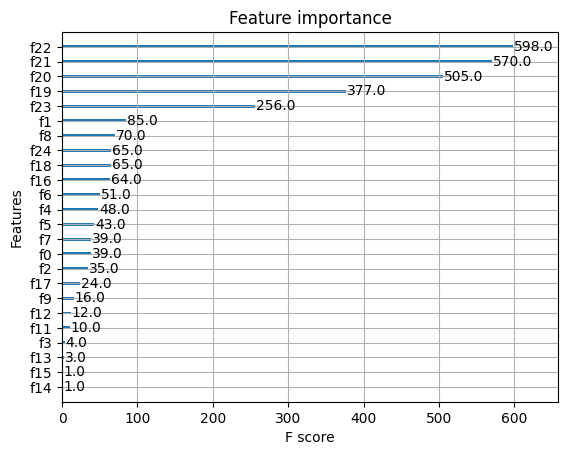

In [86]:
#Applying the XGBoost Model

xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=100,
                            learning_rate=0.1,
                            max_depth=5,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            random_state=42)

start_time = time.time()
xgb_model.fit(features_train_encoded, target_train)
end_time= time.time()
print(f"XGBoost training time on training set: {(end_time - start_time):.2f}")

start_time = time.time()
pred_valid = xgb_model.predict(features_valid_encoded)
end_time= time.time()
print(f"XGBoost prediction time on validation set: {(end_time - start_time):.2f}")

rmse = mse(target_valid, pred_valid, squared=False)
print(f"RMSE on validation set: {rmse:.4f}")

#Obtaining the feature importance for reference
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_model)
plt.show()



The results obtained by the XGBoost are slightly worse than those obtained with the CatBoost and LGBM.

## Applying the best model on the test set

After having used several models to try to obtain the predictions, the CatBoostRegressor without tunning is the one that has given the best results. Due to this, we will apply it to the test set and will obtain the final RMSE. 

In [87]:
#Applying ordinal encoding to the Model and Brand features
columns_to_encode = ['Model', 'Brand']
# Initializing and applying OrdinalEncoder for each column
features_test_encoded = features_test

for col in columns_to_encode:
    encoder = OrdinalEncoder() 
    features_test_encoded[col] = encoder.fit_transform(features_test_encoded[[col]]) 
display(features_test_encoded.head(10))
features_test_encoded.info()

/tmp/ipykernel_1115/3688878113.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test_encoded[col] = encoder.fit_transform(features_test_encoded[[col]])
/tmp/ipykernel_1115/3688878113.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test_encoded[col] = encoder.fit_transform(features_test_encoded[[col]])


,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
92078,wagon,1997,manual,125,30.0,150000,3,petrol,1.0,unknown
222218,sedan,1995,manual,0,91.0,150000,3,petrol,17.0,yes
231004,sedan,2004,manual,116,83.0,150000,8,petrol,36.0,no
309782,small,1996,manual,75,84.0,150000,7,petrol,24.0,unknown
199957,bus,1999,manual,0,166.0,150000,4,petrol,24.0,unknown
222710,suv,2012,auto,136,208.0,50000,11,petrol,15.0,no
96886,sedan,2006,manual,150,6.0,150000,7,petrol,2.0,no
128041,sedan,2006,manual,102,29.0,150000,3,petrol,1.0,no
190035,small,2004,manual,60,176.0,125000,10,petrol,9.0,no
227097,small,2000,manual,56,84.0,150000,3,petrol,24.0,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 55757 entries, 92078 to 178710
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   VehicleType        55757 non-null  object 
 1   RegistrationYear   55757 non-null  int64  
 2   Gearbox            55757 non-null  object 
 3   Power              55757 non-null  int64  
 4   Model              55757 non-null  float64
 5   Mileage            55757 non-null  int64  
 6   RegistrationMonth  55757 non-null  int64  
 7   FuelType           55757 non-null  object 
 8   Brand              55757 non-null  float64
 9   NotRepaired        55757 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 4.7+ MB


In [88]:
#Applying one hot ecoding to the rest of the categorical features
encoded = ['Model', 'Brand']
categoric = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']
numeric = ['RegistrationYear', 'Power', 'Mileage', 'RegistrationMonth']

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

features_enc_test = encoder.fit_transform(features_test_encoded[categoric])

features_enc_df_test = pd.DataFrame(features_enc_test, columns=encoder.get_feature_names(categoric)) 

features_enc_df_test.index = features_test_encoded.index 

features_test_encoded = pd.concat([features_enc_df_test, features_test_encoded[encoded], features_test_encoded[numeric]], axis=1)
display(features_test_encoded.head(10))
display(features_test_encoded.info())

,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_auto,Gearbox_manual,...,FuelType_petrol,NotRepaired_no,NotRepaired_unknown,NotRepaired_yes,Model,Brand,RegistrationYear,Power,Mileage,RegistrationMonth
92078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,30.0,1.0,1997,125,150000,3
222218,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,91.0,17.0,1995,0,150000,3
231004,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,83.0,36.0,2004,116,150000,8
309782,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,84.0,24.0,1996,75,150000,7
199957,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,166.0,24.0,1999,0,150000,4
222710,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,208.0,15.0,2012,136,50000,11
96886,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,6.0,2.0,2006,150,150000,7
128041,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,29.0,1.0,2006,102,150000,3
190035,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,176.0,9.0,2004,60,125000,10
227097,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,84.0,24.0,2000,56,150000,3


<class 'pandas.core.frame.DataFrame'>
Int64Index: 55757 entries, 92078 to 178710
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   VehicleType_bus          55757 non-null  float64
 1   VehicleType_convertible  55757 non-null  float64
 2   VehicleType_coupe        55757 non-null  float64
 3   VehicleType_other        55757 non-null  float64
 4   VehicleType_sedan        55757 non-null  float64
 5   VehicleType_small        55757 non-null  float64
 6   VehicleType_suv          55757 non-null  float64
 7   VehicleType_wagon        55757 non-null  float64
 8   Gearbox_auto             55757 non-null  float64
 9   Gearbox_manual           55757 non-null  float64
 10  FuelType_cng             55757 non-null  float64
 11  FuelType_electric        55757 non-null  float64
 12  FuelType_hybrid          55757 non-null  float64
 13  FuelType_lpg             55757 non-null  float64
 14  FuelType_other   

None

In [89]:
#Scaling the data
scaler = StandardScaler() 
features_test_encoded = scaler.fit_transform(features_test_encoded)

In [90]:
#Applying the CatBoostRegressor model on the test set
start_time = time.time()
pred_test = model_cb.predict(features_test_encoded)

end_time= time.time()
print(f"CatBoost Regressor execution time on test set: {(end_time - start_time):.2f}")

print("Test RMSE: ", np.sqrt(mse(target_test, pred_test)))
display()

CatBoost Regressor execution time on test set: 0.02
Test RMSE:  1667.805684199758


## Model analysis

The fastest model and with the best results was the CatBoostRegressor. On the validation set we obtained an RMSE of 1679.76 and it only took it 10.18 seconds for fitting and 0.03 seconds to generate the predictions.

This is confirmed when applied to the test set, since we are obtaining a final RMSE of 1667.80 and it only takes 0.02 seconds to execute.
